In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func


In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)


In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)
# Get a list of column names and types for Measurement class
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

print('---------------------')

# Get a list of column names and types for Station class
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
---------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()


('2017-08-23',)

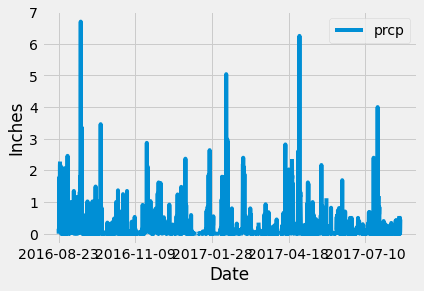

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_results = pd.DataFrame(results)
precip_results = precip_results.set_index('date')

# Sort the dataframe by date
precip_results = precip_results.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
precip_plot = precip_results.plot(), plt.xlabel('Date'), plt.ylabel('Inches')


In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_results.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
session.query(Measurement.station).distinct().count()


9

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(
    Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
single_station_summary = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(
    Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
single_station_summary


('USC00519281', 54.0, 85.0, 71.66378066378067)

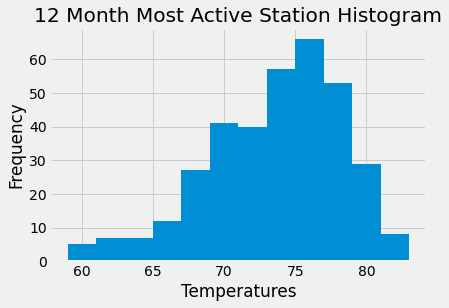

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
histogram_data = session.query(Measurement.tobs).filter(
    Measurement.station == single_station_summary[0]).filter(Measurement.date >= year_ago).all()

df = pd.DataFrame(histogram_data)
station_histogram = df.hist(column='tobs', bins=12), plt.title(
    '12 Month Most Active Station Histogram'), plt.xlabel('Temperatures'), plt.ylabel('Frequency')


# Close session

In [17]:
# Close Session
session.close()
